In [21]:
!pip install ipympl
!pip install astropy
!pip install photutils

In [25]:
%matplotlib widget
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

In [26]:
class Fits:
    def __init__(self, file, print_=True):
        self.file = file
        self.data = {}
        self.header = {}
        open_file = fits.open(self.file)
        if print_:
            open_file.info()
        open_file.close()
        self.read()
        try:
            logging.getLogger("matplotlib").disabled = True
        except:
            pass

    def read(self, hdu=0):
        open_file = fits.open(self.file)
        try:
            self.data[hdu] = open_file[hdu].data.astype(float)
        except (AttributeError, TypeError, ValueError):
            print(rf"HDU {hdu} is not float")
            self.data[hdu] = open_file[hdu].data

        self.header[hdu] = open_file[hdu].header
        open_file.close()

    def wcs_plot(self, hdu=0):
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        fig.add_axes(ax)
        return fig, ax

    def create_copy(self):
        shutil.copy2(self.file, f"{self.file}.copy")

    def image(
        self,
        hdu=0,
        column=False,
        title=None,
        scale=[5, 95],
        save=False,
        tag=None,
        wcs=False,
        median=True,
        meanstd=True,
    ):
        data = self.data[hdu]
        if column:
            data = data[column]
        if not wcs:
            fig, ax = plt.subplots()
            ax.set_xlabel("x pixel")
            ax.set_ylabel("y pixel")
        else:
            wcs_ = WCS(self.header[hdu])
            fig = plt.figure(clear=True)
            ax = plt.subplot(projection=wcs_)
            fig.add_axes(ax)
        self.ax = ax
        if not meanstd and scale:
            try:
                if median:
                    img = np.nanmedian(data, axis=1)
                else:
                    img = data
            except np.AxisError:
                print("invalid shape", data.shape)
                return
            self.scale_low, self.scale_high = np.percentile(img, scale)
            im = ax.imshow(
                data, cmap="magma", vmin=self.scale_low, vmax=self.scale_high
            )
        elif meanstd:
            mean, std = np.nanmean(data), np.nanstd(data)
            vmin = mean - std
            vmax = mean + 10 * std
            im = ax.imshow(
                data,
                interpolation="nearest",
                cmap="gray",
                vmin=vmin,
                vmax=vmax,
                origin="lower",
                # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
            )
        else:
            im = ax.imshow(data, cmap="magma")
        fig.colorbar(im, ax=ax , pad=0.005)
        if not title:
            title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
        ax.set_title(title)
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.png",
                    ),
                    dpi=600,
                )
        fig.tight_layout()
        return ax

    def image_with_reg(
        self, reg, hdu=0, wcsaxis=[0.1, 0.1, 0.8, 0.8], v=[0, 100], save=False, tag=None
    ):
        r = pyregion.open(reg).as_imagecoord(self.header[hdu])
        patch_list, artist_list = r.get_mpl_patches_texts()
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        # ax = WCSAxes(fig,wcsaxis,wcs=wcs)
        fig.add_axes(ax)
        for p in patch_list:
            p.set_color("red")
            p.set_facecolor("none")
            ax.add_patch(p)
        for t in artist_list:
            ax.add_artist(t)

        if v:
            im = ax.imshow(
                self.data[0], origin="lower", vmin=v[0], vmax=v[1], cmap="magma"
            )
        else:
            im = ax.imshow(self.data[0], origin="lower", cmap="magma")
        fig.colorbar(im, cmap="magma")
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.reg.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.reg.png",
                    ),
                    dpi=600,
                )
        # fig.show()
        return ax

    def bin_table(self, hdu=0, return_=True, save=False):
        df = pd.DataFrame(self.data[hdu])
        if save:
            df.to_csv(
                os.path.join(
                    os.path.dirname(self.file), rf"{os.path.basename(self.file)}.csv"
                ),
                encoding="utf-8",
            )
        if return_:
            return df
        else:
            return None

    def bin_table2(self, hdu=0):
        table = QTable(self.data[hdu])
        return table

    def mark_from_cat(self, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red'):
        x_offset = 2
        y_offset = 2
        if cat_file:
            catfits = Fits(cat_file)
            catfits.read(hdu)
            cat = catfits.bin_table2(hdu)
        elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
            cat = cat_table
        else:
            return
        shape = (self.ax.get_xlim()[-1], self.ax.get_ylim()[-1])
        for i, (x, y, a, b, theta) in enumerate(
            zip(
                cat[keys["x"]],
                cat[keys["y"]],
                cat[keys["a"]],
                cat[keys["b"]],
                cat[keys["angle"]],
            )
        ):
            marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
            self.ax.add_patch(marker)
            annotation = str(i)
            try:
                if 'NUMBER' in list(cat.columns):
                    annotation = cat['NUMBER'][i]
            except:
                print('could not access column names')
            if x + x_offset >= shape[0] - x_offset * 2:
                self.ax.annotate(
                    annotation, (x - x_offset*2, y + y_offset), color=color
                )
            else:
                self.ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
        if save:
            plt.savefig(cat_file+'.png',dpi=300)

In [41]:
class MakeFits:
    def __init__(self, data, filename, obsclass="science", **kwargs):
        self.data = data
        self.filename = filename
        self.obsclass = obsclass

        hdu0 = fits.PrimaryHDU(data)
        self.hdul = fits.HDUList([hdu0])
        self.hdul.verify("fix")
        # self.fix_header()
        self.save(**kwargs)

    def fix_header(self):
        header = self.hdul[0].header
        header[OBSCLASS_KEY] = self.obsclass
        header[TARGET_KEY] = self.obsclass
        header[TIME_KEY] = str(datetime.now())
        header[COADD_KEY] = 1
        header[GAIN_KEY] = 1
        header[PROC_HISTORY_KEY] = ""
        header[PROC_FAIL_KEY] = ""
        header[BASE_NAME_KEY] = Path(self.filename).name

    def save(self, **kwargs):
        self.hdul.writeto(self.filename, **kwargs)



In [ ]:
images = []

Filename: /home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (1072, 1027)   int16 (rescales to uint16)   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1072 / length of data axis 1                          
NAXIS2  =                 1027 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBSBLKID=               530784 / Observation Block ID                           
PROPID  =              2370179 / Proposal ID                                    
DATE-OBS= '2023-10-08T09:38:

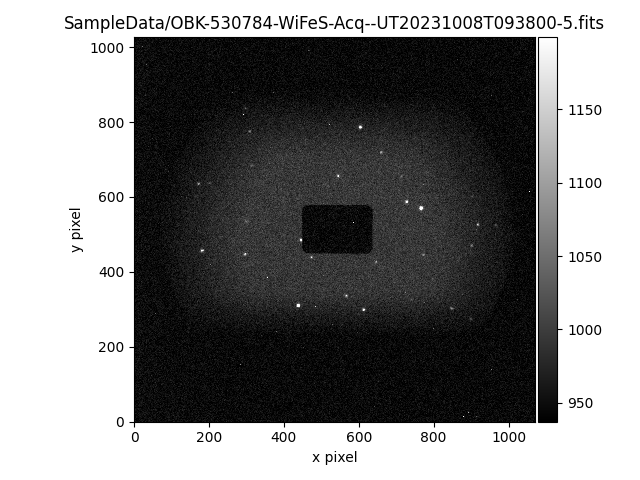

In [88]:
file = Fits('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits')
file.image()
file.header[0]

In [33]:
from photutils.background import Background2D
from photutils.detection import DAOStarFinder


In [35]:
size = file.header[0]['NAXIS1'],file.header[0]['NAXIS2']

In [80]:
size = file.header[0]['NAXIS1'],file.header[0]['NAXIS2']

bkg = Background2D(file.data[0], box_size=(10,10))
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3)
# add bkg med and rms med to header

bkg_path = file.file+'.bkg'
MakeFits(bkg.background,bkg_path,overwrite=True)

In [84]:
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3)

Filename: /home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.bkg
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1072, 1027)   float64   


<Axes: title={'center': 'SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.bkg'}, xlabel='x pixel', ylabel='y pixel'>

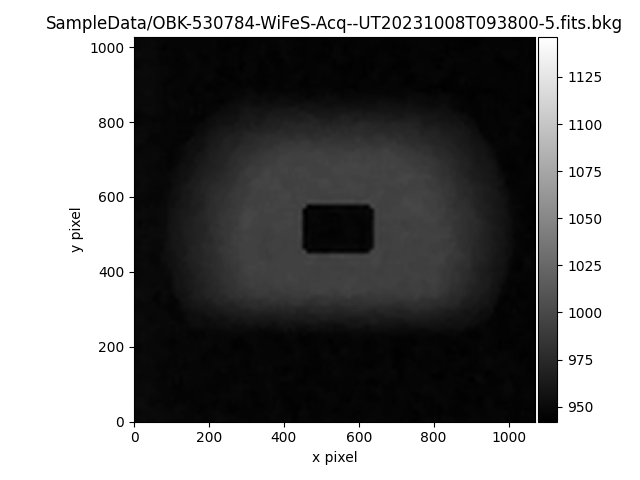

In [85]:
bkg_file = Fits(bkg_path)
bkg_file.image()

In [86]:
bkg_sub_path = file.file+'.bkgsub'
bkg_sub = file.data[0] - bkg.background
MakeFits(bkg_sub,bkg_sub_path,overwrite=True)

Filename: /home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.bkgsub
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1072, 1027)   float64   


<Axes: title={'center': 'SampleData/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.bkgsub'}, xlabel='x pixel', ylabel='y pixel'>

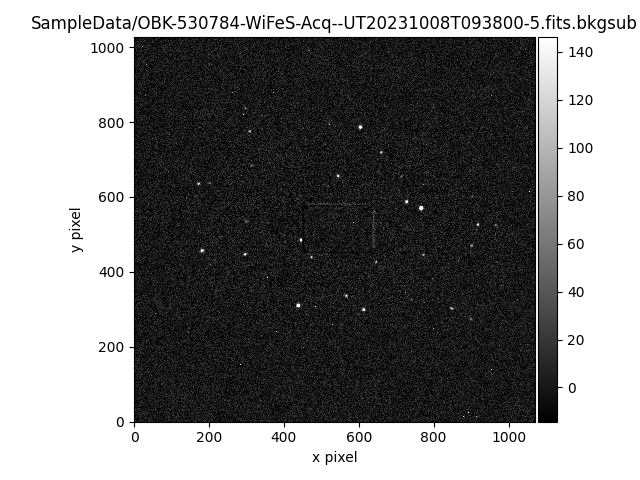

In [87]:
bkg_sub_file = Fits(bkg_sub_path)
bkg_sub_file.image()

In [ ]:
finder = DAOStarFinder()

In [ ]:
class StarDetector(DAOStarFinder):

    def __init__(self):
        threshold = 5
        super().__init__(threshold=threshold)